In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
SSH_train = np.expand_dims(np.load('trainAVISO-SSH_2000-2010.npy'),3)[:,25:168+25,280-168:,:] #you can use all the region, in here I selected a box of 168*168 size
SSH_test = np.expand_dims(np.load('testAVISO-SSH_2011.npy'),3)[:,25:168+25,280-168:,:] 
#######
Seg_train = np.expand_dims(np.load('trainSegmentation_2000-2010.npy'),3)[:,25:168+25,280-168:,:]
Seg_test = np.expand_dims(np.load('testSegmentation_2011.npy'),3)[:,25:168+25,280-168:,:]
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

(4018, 168, 168, 1)

(365, 168, 168, 1)

(4018, 168, 168, 1)

(365, 168, 168, 1)

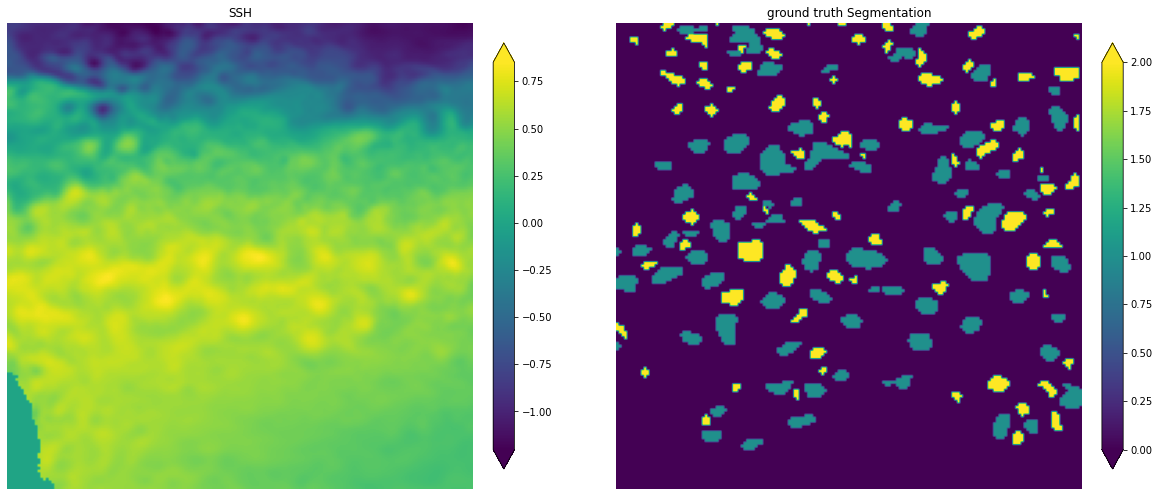

In [3]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras import utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-06-07 22:37:32.963495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
Seg_train_categor = utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(4018,168*168)),3)
Seg_train_categor.shape

(4018, 28224, 3)

In [6]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [7]:
width = 168
height = 168
nbClass = 3
nf = 8
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

2024-06-07 22:39:35.329864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 168, 168, 8)          72        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 168, 168, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 168, 168, 8)          0         ['batch_normalization[0][0

 dropout_3 (Dropout)         (None, 21, 21, 8)            0         ['activation_7[0][0]']        
                                                                                                  
 up_sampling2d (UpSampling2  (None, 42, 42, 8)            0         ['dropout_3[0][0]']           
 D)                                                                                               
                                                                                                  
 concatenate (Concatenate)   (None, 42, 42, 16)           0         ['up_sampling2d[0][0]',       
                                                                     'dropout_2[0][0]']           
                                                                                                  
 conv2d_8 (Conv2D)           (None, 42, 42, 8)            1152      ['concatenate[0][0]']         
                                                                                                  
 batch_nor

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 100434896, 1: 8225760, 2: 4743376}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.02908370281349848, 0.35510623545649606, 0.6158100617300055]

In [10]:

smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

In [12]:
modelcheck = ModelCheckpoint('./weights/eddynetfirst.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

Epoch 1/50


2024-06-07 22:40:08.374957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-07 22:40:09.345416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-07 22:40:10.380850: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbe03179f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 22:40:10.380913: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-07 22:40:10.388277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-07 22:40:10.578703: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

201/201 [==============================] - ETA: 0s - loss: 0.7621 - categorical_accuracy: 0.6433 - mean_dice_coef: 0.3867 - weighted_mean_dice_coef: 0.2380
Epoch 1: val_loss improved from inf to 0.73920, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 20s 43ms/step - loss: 0.7621 - categorical_accuracy: 0.6433 - mean_dice_coef: 0.3867 - weighted_mean_dice_coef: 0.2380 - val_loss: 0.7392 - val_categorical_accuracy: 0.8354 - val_mean_dice_coef: 0.4522 - val_weighted_mean_dice_coef: 0.2611 - lr: 0.0010
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.5907 - categorical_accuracy: 0.8426 - mean_dice_coef: 0.5664 - weighted_mean_dice_coef: 0.4094
Epoch 2: val_loss improved from 0.73920 to 0.65747, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 7s 34ms/step - loss: 0.5907 - categorical_accuracy: 0.8426 - mean_dice_coef: 0.5664 - weighted_mean_dice_coef: 0.4094 - val_loss: 0.6575 - val_categorical

201/201 [==============================] - ETA: 0s - loss: 0.4714 - categorical_accuracy: 0.8905 - mean_dice_coef: 0.6637 - weighted_mean_dice_coef: 0.5286
Epoch 16: val_loss did not improve from 0.44143
201/201 [==============================] - 7s 33ms/step - loss: 0.4714 - categorical_accuracy: 0.8905 - mean_dice_coef: 0.6637 - weighted_mean_dice_coef: 0.5286 - val_loss: 0.4437 - val_categorical_accuracy: 0.8855 - val_mean_dice_coef: 0.6799 - val_weighted_mean_dice_coef: 0.5568 - lr: 0.0010
Epoch 17/50
201/201 [==============================] - ETA: 0s - loss: 0.4707 - categorical_accuracy: 0.8906 - mean_dice_coef: 0.6642 - weighted_mean_dice_coef: 0.5293
Epoch 17: val_loss improved from 0.44143 to 0.44048, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 7s 34ms/step - loss: 0.4707 - categorical_accuracy: 0.8906 - mean_dice_coef: 0.6642 - weighted_mean_dice_coef: 0.5293 - val_loss: 0.4405 - val_categorical_accuracy: 0.8809 - val_mean_dice_coef: 0

Epoch 32/50
201/201 [==============================] - ETA: 0s - loss: 0.4402 - categorical_accuracy: 0.8932 - mean_dice_coef: 0.6834 - weighted_mean_dice_coef: 0.5598
Epoch 32: val_loss did not improve from 0.43425
201/201 [==============================] - 7s 33ms/step - loss: 0.4402 - categorical_accuracy: 0.8932 - mean_dice_coef: 0.6834 - weighted_mean_dice_coef: 0.5598 - val_loss: 0.4421 - val_categorical_accuracy: 0.8872 - val_mean_dice_coef: 0.6810 - val_weighted_mean_dice_coef: 0.5585 - lr: 0.0010
Epoch 33/50
201/201 [==============================] - ETA: 0s - loss: 0.4397 - categorical_accuracy: 0.8931 - mean_dice_coef: 0.6837 - weighted_mean_dice_coef: 0.5603
Epoch 33: val_loss did not improve from 0.43425
201/201 [==============================] - 7s 33ms/step - loss: 0.4397 - categorical_accuracy: 0.8931 - mean_dice_coef: 0.6837 - weighted_mean_dice_coef: 0.5603 - val_loss: 0.4366 - val_categorical_accuracy: 0.8931 - val_mean_dice_coef: 0.6857 - val_weighted_mean_dice_coef

Epoch 48/50
201/201 [==============================] - ETA: 0s - loss: 0.4344 - categorical_accuracy: 0.8943 - mean_dice_coef: 0.6874 - weighted_mean_dice_coef: 0.5656
Epoch 48: val_loss improved from 0.43268 to 0.43159, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 7s 33ms/step - loss: 0.4344 - categorical_accuracy: 0.8943 - mean_dice_coef: 0.6874 - weighted_mean_dice_coef: 0.5656 - val_loss: 0.4316 - val_categorical_accuracy: 0.8846 - val_mean_dice_coef: 0.6876 - val_weighted_mean_dice_coef: 0.5690 - lr: 0.0010
Epoch 49/50
201/201 [==============================] - ETA: 0s - loss: 0.4346 - categorical_accuracy: 0.8946 - mean_dice_coef: 0.6875 - weighted_mean_dice_coef: 0.5654
Epoch 49: val_loss did not improve from 0.43159
201/201 [==============================] - 7s 33ms/step - loss: 0.4346 - categorical_accuracy: 0.8946 - mean_dice_coef: 0.6875 - weighted_mean_dice_coef: 0.5654 - val_loss: 0.4417 - val_categorical_accuracy: 0.8963 - val_mean_

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

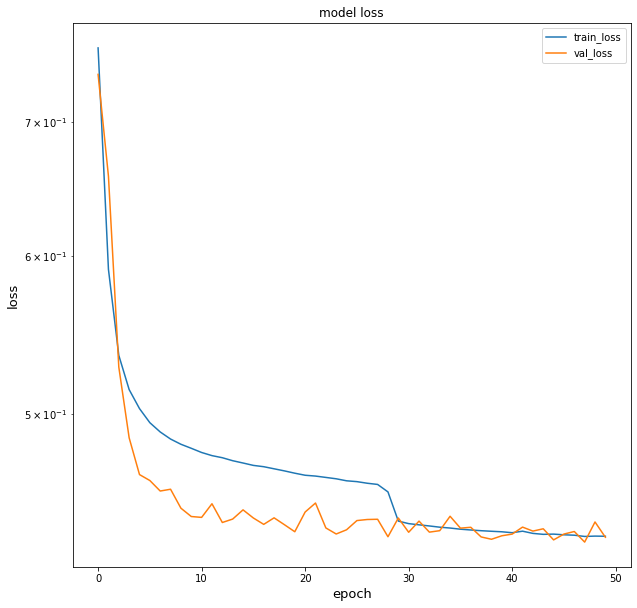

In [18]:
plt.figure(figsize=(10, 10))
plt.semilogy(histeddynet.history['loss'])
plt.semilogy(histeddynet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', fontsize='13')
plt.xlabel('epoch', fontsize='13')
plt.legend(['train_loss', 'val_loss'], loc='upper right');
plt.savefig("results/loss_filters8")

1/1 [==============================] - 0s 44ms/step


<Figure size 1440x720 with 0 Axes>

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'SSH')

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'Eddynet Segmentation')

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'ground truth Segmentation')

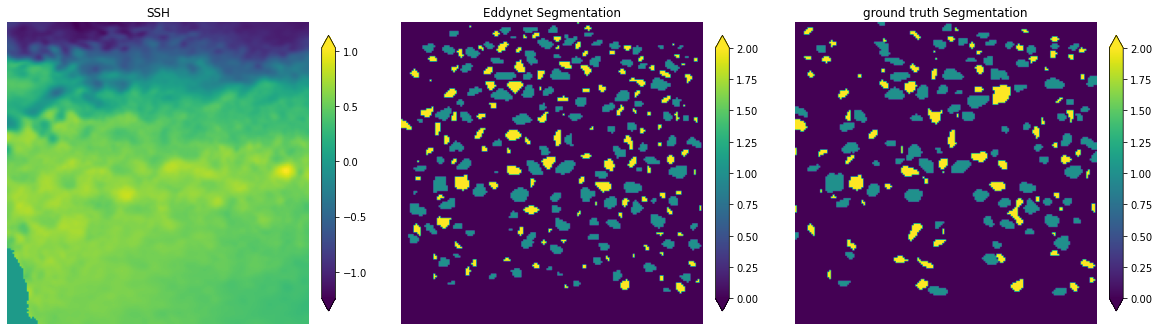

In [19]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');
plt.savefig("segmentation_filters8")